In [ ]:
import os
import pandas as pd
import tensorflow as tf
import pickle
from sklearn.metrics import f1_score, accuracy_score

model_dict = {}

results = {
    'Subset': [],
    'F1-score': [],
    'Accuracy - class Anxiety': [],
    'Accuracy - class Depression': [],
    'Rows in test set': []
}

# Load Keras model
model = tf.keras.models.load_model('models/NN_CAT_best_model.keras')
pipeline = pickle.load(open('models/NN_CAT_pipeline.pkl', 'rb'))

# Loop through all demographic test sets
for x_file in os.listdir('demographics/X_test'):
    if not x_file.endswith('.csv'):
        continue  # Skip non-csv files

    # Prepare file names
    subset_name = x_file.replace('.csv', '').replace('X_test_', '')
    y_file = x_file.replace('X_test', 'y_test')

    # Load data
    X_test = pipeline.transform(pd.read_csv(os.path.join('demographics/X_test', x_file)))
    y_test = pd.read_csv(os.path.join('demographics/y_test', y_file))

    # Ensure input is numpy array
    # Predict probabilities (shape: [n_samples, 2])
    y_pred_proba = model.predict(X_test)

    # Convert probabilities to binary predictions (threshold 0.5)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Compute metrics
    f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
    acc_anxiety = round(accuracy_score(y_test.iloc[:, 0], y_pred[:, 0]), 3)
    acc_depression = round(accuracy_score(y_test.iloc[:, 1], y_pred[:, 1]), 3)

    # Store results
    results['Subset'].append(subset_name)
    results['F1-score'].append(f1)
    results['Accuracy - class Anxiety'].append(acc_anxiety)
    results['Accuracy - class Depression'].append(acc_depression)
    results['Rows in test set'].append(X_test.shape[0])

    model_dict[subset_name] = {
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }
    
# Convert results to DataFrame
df_results = pd.DataFrame(results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Users/markv98/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


In [3]:
df_results.sort_values(by='F1-score', ascending=False)

,Subset,F1-score,Accuracy - class Anxiety,Accuracy - class Depression,Rows in test set
0,18,0.740,0.622,0.657,143
2,female,0.729,0.653,0.588,323
5,30_39,0.722,0.673,0.545,55
1,19_29,0.708,0.602,0.565,186
4,male,0.684,0.482,0.660,141
3,40,0.681,0.500,0.700,30


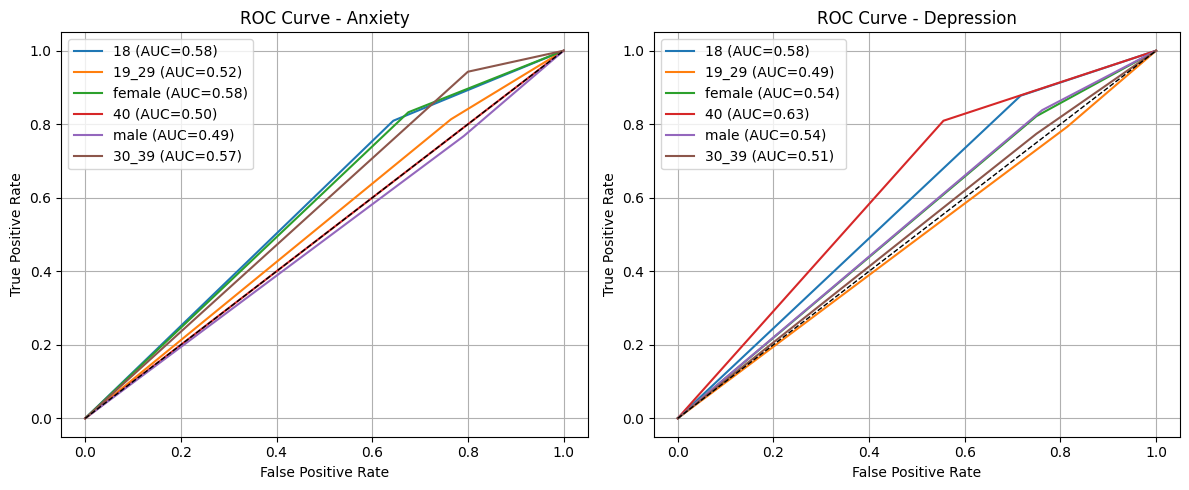

In [6]:
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

labels = ['Anxiety', 'Depression']
for i, label in enumerate(labels):
    plt.subplot(1, 2, i+1)
    for subset, d in model_dict.items():
        # Get true labels and predicted probabilities
        y_true = d['y_test'].iloc[:, i]
        # Get predicted probabilities if available, else use predictions
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(d['X_test'])[i][:, 1]
        else:
            # fallback: use predictions as probabilities (not ideal)
            y_score = d['y_pred'][:, i]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{subset} (AUC={roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f'ROC Curve - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()